# Cascaded calibration of subcatchments defined by multiple gauges

## Use case

**2021-01: this vignette works structurally, but is confined to overly short (and possibly difficult) data to keep runtime low**

This vignette demonstrates how one can calibrate a catchment using multiple gauging points available within this catchment. Instead of setting up a whole-of-catchment calibration definition, it makes sense, at least in a system where subareas above a gauge points do not have a behavior dependent on other catchment processes (meaning mostly, no managed reservoirs). SWIFT offers capabilities to calibrate such subcatchments sequentially, feeding the input flow of upstream and already calibrated subcatchments to other subcatchments, thus cutting down on the complexity and runtime of the overall catchment calibration. 

In [1]:
from collections import OrderedDict
from swift2.classes import CompositeParameteriser, ObjectiveEvaluator, Simulation
from swift2.const import CATCHMENT_FLOWRATE_VARID
from swift2.vis import plot_two_series
import numpy as np

In [2]:
import swift2.doc_helper as std
import swift2.parameteriser as sp

In [3]:
from cinterop.timeseries import xr_ts_start, xr_ts_end
import datetime as dt

In [4]:
%matplotlib inline

## Data

The sample data that comes with the package contains a model definition for the South Esk catchment, including a short subset of the climate and flow record data.

In [5]:
model_id = 'GR4J'
site_id = 'South_Esk'
simulation = std.sample_catchment_model(site_id=site_id, config_id='catchment')
simulation = simulation.swap_model('LagAndRoute', 'channel_routing')

A visual of the catchment structure (note: may not render yet through GitHub)

In [6]:
# DiagrammeR(getCatchmentDotGraph(simulation))
# TODO...
# https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
# https://medium.com/@ludvig.hult/drawing-graphs-with-python-in-2019-bdd42bf9d5db

In [7]:
se_climate = std.sample_series(site_id=site_id, var_name='climate')
se_flows = std.sample_series(site_id=site_id, var_name='flow')

In [8]:
# se_climate["subcatchment.5.P"].plot()

The names of the climate series is already set to the climate input identifiers of the model simulation, so setting them as inputs is easy:

In [9]:
se_climate.head(3)

,subcatchment.1.E,subcatchment.1.P,subcatchment.10.E,subcatchment.10.P,subcatchment.11.E,subcatchment.11.P,subcatchment.12.E,subcatchment.12.P,subcatchment.13.E,subcatchment.13.P,...,subcatchment.5.E,subcatchment.5.P,subcatchment.6.E,subcatchment.6.P,subcatchment.7.E,subcatchment.7.P,subcatchment.8.E,subcatchment.8.P,subcatchment.9.E,subcatchment.9.P
2010-11-01 00:00:00,0.3918,0.0,0.4020,0.0000,0.3978,0.0000,0.4266,0.0000,0.3936,0.0000,...,0.4325,0.0,0.4110,0.0322,0.4247,0.0,0.4377,0.0,0.4337,0.0
2010-11-01 01:00:00,0.4385,0.0,0.4493,0.0207,0.4446,0.0433,0.4763,0.0179,0.4397,0.0555,...,0.4823,0.0,0.4593,0.0000,0.4746,0.0,0.4892,0.0,0.4841,0.0
2010-11-01 02:00:00,0.4614,0.0,0.4723,0.0000,0.4671,0.0000,0.5002,0.0000,0.4619,0.0000,...,0.5060,0.0,0.4827,0.0000,0.4987,0.0,0.5143,0.0,0.5084,0.0


In [10]:
simulation.play_input(se_climate)
simulation.set_simulation_span(xr_ts_start(se_climate), xr_ts_end(se_climate))
simulation.set_simulation_time_step('hourly')

The `doc_helper` submodule has helper functions to configure the gr4j model to such that it is fit to run on hourly data:

In [11]:
std.configure_hourly_gr4j(simulation)

## Parameterisation

We define a function creating a realistic feasible parameter space. This is not the main object of this vignette, so we do not describe in details. 

In [12]:

from swift2.utils import as_xarray_series, c, paste0, rep
import swift2.parameteriser as sp
import swift2.helpers as hlp


def create_meta_parameteriser(simulation:Simulation, ref_area=250, time_span=3600):  
    time_span = int(time_span)
    parameteriser = std.define_gr4j_scaled_parameter(ref_area, time_span)
  
    # Let's define _S0_ and _R0_ parameters such that for each GR4J model instance, _S = S0 * x1_ and _R = R0 * x3_
    p_states = sp.linear_parameteriser(
                      param_name=c("S0","R0"), 
                      state_name=c("S","R"), 
                      scaling_var_name=c("x1","x3"),
                      min_p_val=c(0.0,0.0), 
                      max_p_val=c(1.0,1.0), 
                      value=c(0.9,0.9), 
                      selector_type='each subarea')
  
    init_parameteriser = p_states.make_state_init_parameteriser()
    parameteriser = sp.concatenate_parameterisers(parameteriser, init_parameteriser)
    
    hlp.lag_and_route_linear_storage_type(simulation)
    hlp.set_reach_lengths_lag_n_route(simulation)

    lnrp = hlp.parameteriser_lag_and_route()
    parameteriser = CompositeParameteriser.concatenate(parameteriser, lnrp, strategy='')
    return parameteriser

In [13]:
parameteriser = create_meta_parameteriser(simulation)
parameteriser.as_dataframe()

,Name,Value,Min,Max
0,log_x4,0.305422,0.000000,2.380211
1,log_x1,0.506690,0.000000,3.778151
2,log_x3,0.315425,0.000000,3.000000
3,asinh_x2,2.637752,-3.989327,3.989327
4,R0,0.900000,0.000000,1.000000
5,S0,0.900000,0.000000,1.000000
6,alpha,1.000000,0.001000,100.000000
7,inverse_velocity,1.000000,0.001000,100.000000


Now, checking that a default parameter set works structurally on the simulation:

In [14]:
parameteriser.set_parameter_value('asinh_x2', 0)
parameteriser.apply_sys_config(simulation)
simulation.exec_simulation()

We are now ready to enter the main topic of this vignette, subsetting the catchment into subcatchments for calibration purposes.

## Splitting the catchment in subcatchments

The sample gauge data flow contains identifiers that are of course distinct from the network node identifiers. We create a map between them (note - this information used to be in the NodeLink file in swiftv1), and we use these node as splitting points to derive subcatchments

In [15]:
gauges = c( '92106', '592002', '18311', '93044',    '25',   '181')
node_ids = paste0('node.', c('7',   '12',   '25',   '30',   '40',   '43'))
node_gauges = OrderedDict([(node_ids[i], gauges[i]) for i in range(len(gauges))])
# names(gauges) = node_ids

### Test running and recording streamflows

In [16]:
simulation.get_variable_ids(node_ids[0])

['node.7.InflowRate',
 'node.7.InflowVolume',
 'node.7.AdditionalInflowRate',
 'node.7.OutflowRate',
 'node.7.OutflowVolume']

In [17]:
simulation.record_state(paste0(node_ids, ".OutflowRate"))

In [18]:
simulation.exec_simulation()

In [19]:
modelled = simulation.get_all_recorded()

In [20]:
modelled

<xarray.DataArray (variable_identifiers: 6, ensemble: 1, time: 480)>
array([[[11.80066449,  7.44947703, 18.42497666, ...,  0.28179863,
          0.27663744,  0.27165243]],

       [[11.19512081,  6.66918055, 12.49597281, ...,  0.38460207,
          0.38065825,  0.37679025]],

       [[ 6.83285487, 10.68999615, 17.44945727, ...,  2.26019515,
          2.22860765,  2.19794827]],

       [[11.86391178, 12.88237054, 11.40568098, ...,  0.13346021,
          0.13235124,  0.13125882]],

       [[19.862354  , 11.83475444,  8.23442729, ...,  3.61385335,
          3.55119926,  3.49124398]],

       [[20.9016399 , 23.51593328, 28.95913953, ...,  0.43200931,
          0.42719557,  0.42247987]]])
Coordinates:
  * ensemble              (ensemble) int64 0
  * time                  (time) datetime64[ns] 2010-11-01 ... 2010-11-20T23:...
  * variable_identifiers  (variable_identifiers) object 'node.12.OutflowRate'...

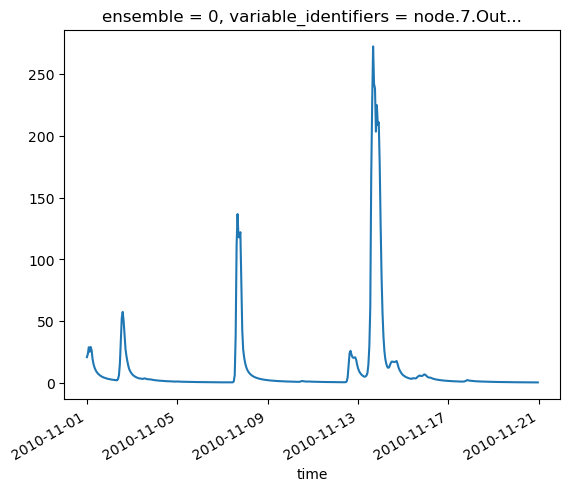

In [21]:
modelled.sel(variable_identifiers='node.7.OutflowRate').plot()

<Axes: >

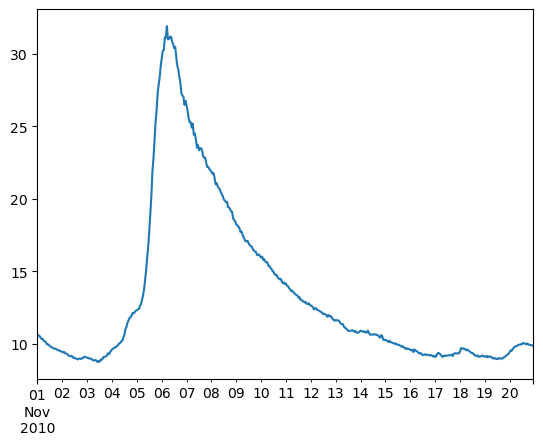

In [22]:
se_flows[gauges[3]].plot()

In [23]:
split_element_ids = node_ids
sub_cats = simulation.split_to_subcatchments(split_element_ids)
sub_cats

OrderedDict([('node.40',
              Simulation wrapper for a CFFI pointer handle to a native pointer of type id "MODEL_SIMULATION_PTR"),
             ('node.25',
              Simulation wrapper for a CFFI pointer handle to a native pointer of type id "MODEL_SIMULATION_PTR"),
             ('node.12',
              Simulation wrapper for a CFFI pointer handle to a native pointer of type id "MODEL_SIMULATION_PTR"),
             ('node.7',
              Simulation wrapper for a CFFI pointer handle to a native pointer of type id "MODEL_SIMULATION_PTR"),
             ('node.30',
              Simulation wrapper for a CFFI pointer handle to a native pointer of type id "MODEL_SIMULATION_PTR"),
             ('node.43',
              Simulation wrapper for a CFFI pointer handle to a native pointer of type id "MODEL_SIMULATION_PTR")])

The resulting list of subcatchment simulations is already ordered in an upstream to downstream order by SWIFT.

If we are to set up the first step of the sequential calibration:

In [24]:
sub_cats['node.40'].describe()

{'subareas': {'37': 'Subarea_37', '38': 'Subarea_38', '39': 'Subarea_39'},
 'nodes': {'40': 'Node_40', '39': 'Node_39', '38': 'Node_38', '37': 'Node_37'},
 'links': {'39': 'Subarea_39', '38': 'Subarea_38', '37': 'Subarea_37'}}

In [25]:
def first(d:OrderedDict):
    return list(sub_cats.items())[0]  

In [26]:
element_id = first(sub_cats)[0]
element_id

'node.40'

In [27]:
gaugeId = node_gauges[element_id]
gaugeId

'25'

In [28]:
gauge_flow = se_flows[[gaugeId]]
gauge_flow.head()

,25
2010-11-01 00:00:00,1.229
2010-11-01 01:00:00,1.259
2010-11-01 02:00:00,1.280
2010-11-01 03:00:00,1.291
2010-11-01 04:00:00,1.296


In [29]:
sc = sub_cats[element_id]
sc

Simulation wrapper for a CFFI pointer handle to a native pointer of type id "MODEL_SIMULATION_PTR"

In [30]:
parameteriser.apply_sys_config(sc)
var_id = CATCHMENT_FLOWRATE_VARID
sc.record_state(var_id)

In [31]:
# DiagrammeR(getCatchmentDotGraph(sc))

Let's view the default, uncalibrated output 

In [32]:
simulation.get_simulation_span()

{'start': datetime.datetime(2010, 11, 1, 0, 0),
 'end': datetime.datetime(2010, 11, 20, 23, 0),
 'time step': 'hourly'}

In [33]:
def plot_obs_vs_calc(obs, calc, ylab="streamflow (m3/s)"):
    plot_two_series(obs, calc, start_time = xr_ts_start(obs), end_time = xr_ts_end(obs))

In [34]:
gauge_flow = as_xarray_series(gauge_flow)

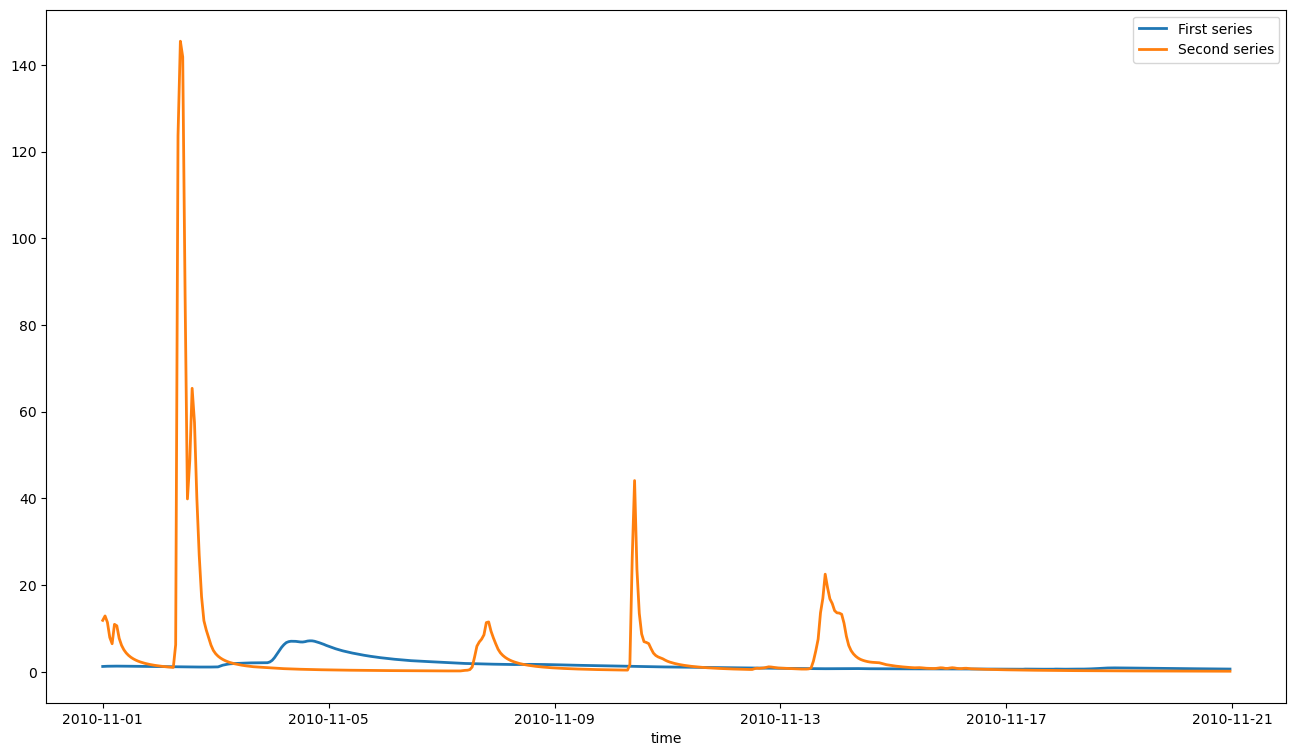

In [35]:
sc.exec_simulation()
plot_obs_vs_calc(gauge_flow, sc.get_recorded(var_id))

Now, setting up an objective (NSE) and optimiser:

In [36]:
objectiveId = 'NSE'
objective = sc.create_objective(var_id, gauge_flow, objectiveId, xr_ts_start(se_flows), xr_ts_end(se_flows))
score = objective.get_score(parameteriser)  

In [37]:
# termination = getMarginalTermination( tolerance = 1e-04, cutoff_no_improvement = 30, max_hours = 2/60) 
termination = sp.create_sce_termination_wila('relative standard deviation', c('0.05','0.0167'))
sce_params = sp.get_default_sce_parameters()
params = parameteriser.as_dataframe()

In [38]:
np.count_nonzero(abs(params.Max-params.Min)>0)

8

In [39]:
npars = np.count_nonzero(abs(params.Max-params.Min)>0)
sce_params = std.sce_parameter(npars)
optimiser = objective.create_sce_optim_swift(termination_criterion = termination, population_initialiser = parameteriser,sce_params = sce_params)
calib_logger = optimiser.set_calibration_logger("dummy")

In [40]:
%%time
calib_results = optimiser.execute_optimisation()

CPU times: user 27.5 s, sys: 55 ms, total: 27.5 s
Wall time: 4.86 s


And the resulting hydrograph follows. The NSE score is decent, but the magnitude of the peak is not well represented. We used a uniform value for the routing parameters; having a scaling based on link properties may be a line of enquiry.

In [41]:
sorted_results = calib_results.sort_by_score('NSE')
d = sorted_results.as_dataframe()
d.head()

,NSE,log_x4,log_x1,log_x3,asinh_x2,R0,S0,alpha,inverse_velocity
0,0.494486,2.083412,0.817456,0.543006,0.201668,0.486912,0.566229,52.931056,57.135610
1,0.494270,2.088946,0.877532,0.480031,0.212400,0.436573,0.525331,53.521435,53.435698
2,0.494118,2.078820,0.853538,0.527632,0.234605,0.474694,0.510408,48.404811,55.239899
3,0.493718,2.084039,0.874168,0.521461,0.239327,0.483183,0.534643,52.075063,50.367980
4,0.493551,2.093115,0.853368,0.481468,0.214864,0.509028,0.536058,53.395207,55.080122


In [42]:
d.tail()

,NSE,log_x4,log_x1,log_x3,asinh_x2,R0,S0,alpha,inverse_velocity
165,0.482992,2.079494,0.812588,0.494737,0.140989,0.497908,0.522849,46.473800,54.568243
166,0.482560,2.062943,0.781697,0.596623,0.220231,0.527801,0.552285,54.745652,67.971298
167,0.482497,2.106522,0.829144,0.412829,0.138130,0.530156,0.593584,52.202333,60.017567
168,0.482294,2.081617,0.908696,0.424188,0.211116,0.516536,0.477412,54.026519,48.048843
169,0.482252,2.086505,0.738809,0.564237,0.093866,0.515100,0.493760,54.961603,53.276150


In [43]:
p = sorted_results.get_parameters_at_index(1)
p

               Name      Value       Min         Max
0            log_x4   2.083412  0.000000    2.380211
1            log_x1   0.817456  0.000000    3.778151
2            log_x3   0.543006  0.000000    3.000000
3          asinh_x2   0.201668 -3.989327    3.989327
4                R0   0.486912  0.000000    1.000000
5                S0   0.566229  0.000000    1.000000
6             alpha  52.931056  0.001000  100.000000
7  inverse_velocity  57.135610  0.001000  100.000000

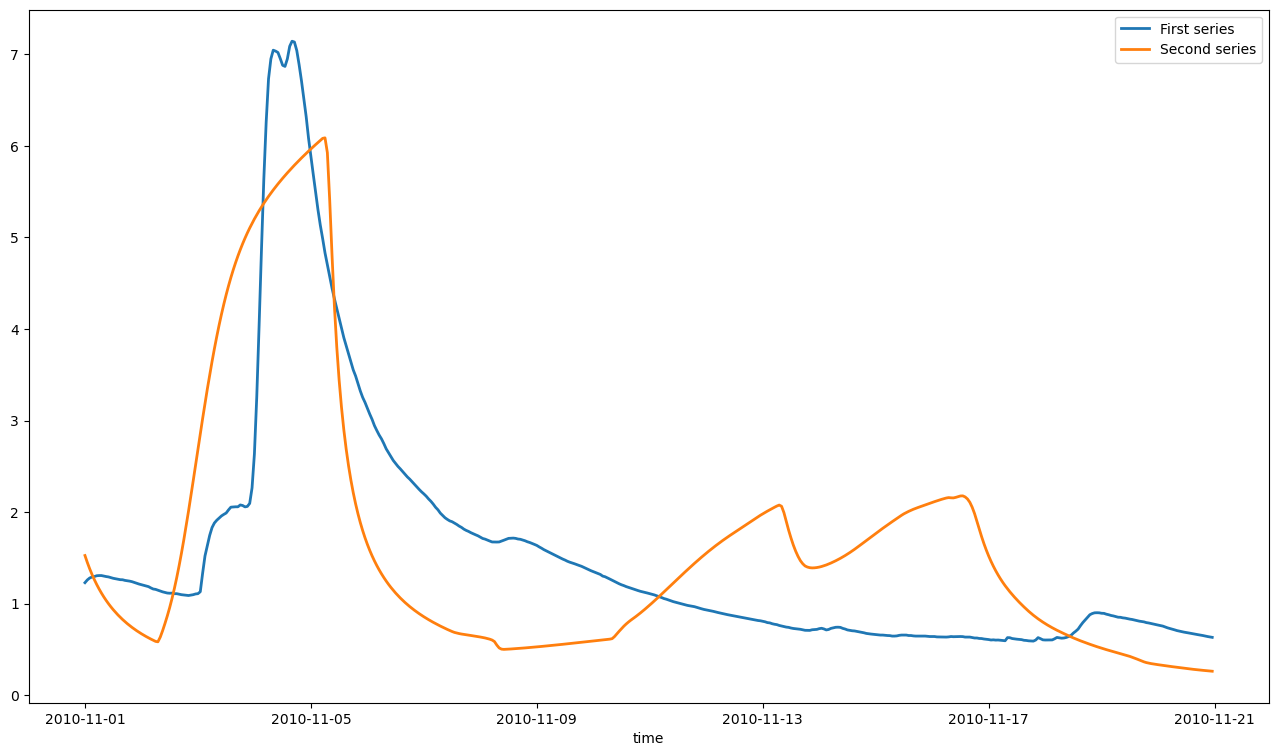

In [44]:
p.apply_sys_config(sc)
sc.exec_simulation()
plot_obs_vs_calc(gauge_flow, sc.get_recorded(var_id))

We can create a subcatchment parameteriser, such that when applied to the whole of the South Esk, only the states of the subareas, links and nodes of the subcatchment are potentially affected.

In [45]:
sp = p.subcatchment_parameteriser(sc)
sp.apply_sys_config(simulation)
simulation.get_state_value(paste0('subarea.', np.arange(34,stop=41), '.x2'))
# saIds = get_subarea_ids(simulation)

{'subarea.34.x2': 0.0,
 'subarea.35.x2': 0.0,
 'subarea.36.x2': 0.0,
 'subarea.37.x2': 0.13603542953576564,
 'subarea.38.x2': 0.13603542953576564,
 'subarea.39.x2': 0.13603542953576564,
 'subarea.40.x2': 0.0}

In [46]:
# TODO
# spFile = tempfile()
# SaveParameterizer_R(sp, spFile)
# # Following fails 2020-06, see https://jira.csiro.au/browse/WIRADA-631 
# # sp2 = LoadParameterizer_R(spFile)

# if(file.exists(spFile)) { file.remove(spFile) }

In [47]:
p = sorted_results.get_parameters_at_index(1)
p.as_dataframe()

,Name,Value,Min,Max
0,log_x4,2.083412,0.000000,2.380211
1,log_x1,0.817456,0.000000,3.778151
2,log_x3,0.543006,0.000000,3.000000
3,asinh_x2,0.201668,-3.989327,3.989327
4,R0,0.486912,0.000000,1.000000
5,S0,0.566229,0.000000,1.000000
6,alpha,52.931056,0.001000,100.000000
7,inverse_velocity,57.135610,0.001000,100.000000


In [48]:
# swoop(sc, p, param_name, from, to, num=10, var_id) {
#   if(missing(from)) { from = GetParameterMinValue_R(p, param_name)}
#   if(missing(to))   { to = GetParameterMaxValue_R(p, param_name)}
#   oat(sc, p, param_name, from=from, to=to, num=num, var_id) 
# }

# testp(sim, p, ...) {
#   q = CloneHypercubeParameterizer_R(p)
#   execSimulation(sim)
#   params = list(...)
#   for(pname in names(params)) {set_parameter_value(q, pname, params[[pname]])}
#   plot_obs_vs_calc(gaugeFlow, getRecorded(sim, var_id))
# }

# flows = swoop(sc, p, 'log_x4', var_id=var_id)

# flows = swoop('log_x1')
# flows = swoop('Alpha')
# flows = merge(flows, gaugeFlow)
# zoo::plot.zoo(flows, plot.type='single')
# col=c('orange', 'black','blue','red')

# f(...) {
# params = list(...)
# params
# set_parameter_value(p, names(params), as.numeric(params))
# applySysConfig(p, sc)
# execSimulation(sc)
# plot_obs_vs_calc(gaugeFlow, getRecorded(sc, var_id))
# }

## Whole of catchment calibration combining point gauges

In [49]:
gauges = c( '92106', '592002', '18311', '93044',    '25',   '181')
node_ids = paste0('node.', c('7',   '12',   '25',   '30',   '40',   '43'))
node_gauges = OrderedDict([(node_ids[i], gauges[i]) for i in range(len(gauges))])
# names(gauges) = node_ids

In [50]:
calibNodes = paste0('node.', ["7","12"])



In [51]:
element_id = first(sub_cats)[0]
element_id

'node.40'

In [52]:
gaugeId = [node_gauges[k] for k in calibNodes]
gauge_flow = se_flows[gaugeId]

In [53]:
sc = sub_cats[element_id]
parameteriser.apply_sys_config(sc)

var_id = paste0(calibNodes, '.OutflowRate')
simulation.record_state(var_id)

In [54]:
objectiveId = 'NSE'

def create_obj_station(i:int):
    obs = as_xarray_series(gauge_flow[[gaugeId[i]]])
    return simulation.create_objective(var_id[i], obs, objectiveId, xr_ts_start(se_flows), xr_ts_end(se_flows))

objectives = [create_obj_station(i) for i in [0,1]]

co = ObjectiveEvaluator.create_composite_objective(objectives, [1.0,1.0], var_id[:2])

In [55]:
score = co.get_score(parameteriser) 
# scoresAsDataFrame(score)

In [56]:
score

{'scores': {'NSE:1.000000,NSE:1.000000': -255.57587357245515},
 'sysconfig':                Name     Value       Min         Max
 0            log_x4  0.305422  0.000000    2.380211
 1            log_x1  0.506690  0.000000    3.778151
 2            log_x3  0.315425  0.000000    3.000000
 3          asinh_x2  0.000000 -3.989327    3.989327
 4                R0  0.900000  0.000000    1.000000
 5                S0  0.900000  0.000000    1.000000
 6             alpha  1.000000  0.001000  100.000000
 7  inverse_velocity  1.000000  0.001000  100.000000}